In [1]:
from ict_eeio.mrio import (
    get_all_industries,
    load_base,
    get_demand_categories,
    get_industry_output,
    get_monetary_flow,
    get_factor_input_per_Y_unit,
    get_leontief_flow,
    aggregate_sectors,
    get_total_final_demand,
)

from ict_eeio.eeio import (
    get_direct_impact_coefficient,
    get_cba_impact,
    get_pba_impact,
    get_total_direct_impact,
    get_all_satellites_stressors,
)
from ict_eeio.industries import ict_industries, energy_industries
from ict_eeio.satellites import (
    impact_stressors_used,
    impact_stressors_unused,
    satellites,
    impacts,
    clear_mineral_stressors_name,
)
from ict_eeio.sankey import plot_sankey
import pandas as pd
from collections import OrderedDict

# libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from ict_eeio.satellites import (
    mineral_stressors,
    mineral_stressors_used,
    mineral_stressors_unused,
)

# Set seaborn theme for matplotlib
sns.set_theme()

/Users/thibaultsimon/Documents/projects/thesis/1_eeioa/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
path = "./data/new/ixi/cba_stressor/"
# energy_file = path + "energy_agg_1995_2022_agg.csv"
ict_file = path + "ict_agg_1995_2022.csv"
all_file = path + "all_1995_2022.csv"
ict_simp_file = path + "ict_agg_1995_2022_simplified.csv"

ict = pd.read_csv(ict_file, index_col=[0, 1])
# energy = pd.read_csv(energy_file, index_col=[0, 1])
all_sectors = pd.read_csv(all_file, index_col=[0, 1])
ict_simp = pd.read_csv(ict_simp_file, index_col=[0, 1])

# Filter the DataFrame to include only years up to 2021
ict = ict.loc[ict.index.get_level_values(0) <= 2021]
all_sectors = all_sectors.loc[all_sectors.index.get_level_values(0) <= 2021]
ict_simp = ict_simp.loc[ict_simp.index.get_level_values(0) <= 2021]

mineral_categories = [
    "Domestic Extraction Used - Metal Ores - Copper ores",
    "Domestic Extraction Used - Metal Ores - Nickel ores",
    "Domestic Extraction Used - Metal Ores - Tin ores",
]
# mineral_categories = mineral_stressors_used

In [3]:
ict.index

MultiIndex([(1995,                           'Cultivation of paddy rice'),
            (1995,                                'Cultivation of wheat'),
            (1995,                    'Cultivation of cereal grains nec'),
            (1995,              'Cultivation of vegetables, fruit, nuts'),
            (1995,                            'Cultivation of oil seeds'),
            (1995,               'Cultivation of sugar cane, sugar beet'),
            (1995,                   'Cultivation of plant-based fibers'),
            (1995,                            'Cultivation of crops nec'),
            (1995,                                      'Cattle farming'),
            (1995,                                        'Pigs farming'),
            ...
            (2021,                            'Landfill of waste: Paper'),
            (2021,                          'Landfill of waste: Plastic'),
            (2021,            'Landfill of waste: Inert/metal/hazardous'),
         

## Functions


In [4]:
def plot_minerals(
    dataframe: pd.DataFrame, agg_name: str, categories: list[str], col_wrap=2
):
    values = []
    labels = []
    years = dataframe.index.get_level_values(0).unique()

    # Shift the data
    for category in categories:
        labels.extend(
            np.repeat(clear_mineral_stressors_name(category), len(years))
        )  # Repeat label for each year
        values.extend(dataframe.xs(agg_name, level=1)[category].values)

    # Create a dataset
    df = pd.DataFrame(
        {
            "mineral": labels,
            "years": list(years) * len(categories),
            "Gt": values,
        }
    )

    # Create a grid : initialize it
    g = sns.FacetGrid(df, col="mineral", hue="mineral", col_wrap=col_wrap, sharey=False)

    # Add the line over the area with the plot function
    g = g.map(plt.plot, "years", "Gt")

    # Fill the area with fill_between
    g = g.map(plt.fill_between, "years", "Gt", alpha=0.2).set_titles("{col_name}")

    # Control the title of each facet
    g = g.set_titles("{col_name}")


def clear_industry_name(industry: str):
    if industry == "Manufacture of machinery and equipment n.e.c.":
        return "Manufacture of machinery\nand equipment n.e.c."
    elif industry == "Manufacture of motor vehicles, trailers and semi-trailers":
        return "Manufacture of motor vehicles,\ntrailers and semi-trailers"
    elif industry == "Manufacture of electrical machinery and apparatus n.e.c.":
        return "Manufacture of electrical machinery\nand apparatus n.e.c."
    elif industry == "Public administration and defence; compulsory social security":
        return "Public administration and defence;\ncompulsory social security"
    else:
        return industry


def plot_detailed_minerals(
    dataframe: pd.DataFrame,
    industries_threshold: 10,
    categories: list[str],
    col_wrap=2,
    fill=True,
):
    values = []
    labels = []
    industries = []
    years = []
    years_unique = dataframe.index.get_level_values(0).unique()

    # Do not consider Mining industries
    mask = ~dataframe.index.get_level_values(1).str.contains("Mining")

    # Apply the mask to the DataFrame to filter out the rows
    df_filtered = dataframe[mask]

    # Shift the data
    for category in categories:
        # Keep the n largest industries
        largest_industries = list(
            df_filtered[category]
            .groupby(level=1)
            .sum()
            .nlargest(industries_threshold)
            .index
        )
        if "ICT" not in largest_industries:
            largest_industries.append("ICT")

        # Iterate through wanted_industries
        for industry in largest_industries:
            # Repeat label, years and industry for each industry
            labels.extend(
                np.repeat(clear_mineral_stressors_name(category), len(years_unique))
            )
            industries.extend(
                np.repeat(clear_industry_name(industry), len(years_unique))
            )
            years.extend(years_unique)
            values.extend(df_filtered.xs(industry, level=1)[category].values)

    # Create a dataset
    df = pd.DataFrame(
        {
            "mineral": labels,
            "industries": industries,
            "years": years,
            "Gt": values,
        }
    )

    # Create a grid : initialize it
    g = sns.FacetGrid(
        df,
        col="mineral",
        hue="industries",
        col_wrap=col_wrap,
        sharey=False,
        palette="bright",
    )

    # Add the line over the area with the plot function
    g = g.map(plt.plot, "years", "Gt")

    # Fill the area with fill_between
    if fill:
        g = g.map(plt.fill_between, "years", "Gt", alpha=0.2).set_titles("{col_name}")

    # Control the title of each facet
    g = g.set_titles("{col_name}")

    # Add hue legend
    g.add_legend()


def compare_minerals(
    first_dataframe: pd.DataFrame,
    first_agg_name: str,
    second_dataframe: pd.DataFrame,
    second_agg_name: str,
    categories: list[str],
    fill=True,
):
    values = []
    labels = []
    industries = []
    years = []
    years_unique = first_dataframe.index.get_level_values(0).unique()

    # Shift the data
    for category in categories:
        # We repeat label, industry and year for each industry

        # First industry
        labels.extend(
            np.repeat(clear_mineral_stressors_name(category), len(years_unique))
        )
        industries.extend(np.repeat(first_agg_name, len(years_unique)))
        years.extend(years_unique)

        values.extend(first_dataframe.xs(first_agg_name, level=1)[category].values)

        # Second industry
        labels.extend(
            np.repeat(clear_mineral_stressors_name(category), len(years_unique))
        )
        industries.extend(np.repeat(second_agg_name, len(years_unique)))
        years.extend(years_unique)

        values.extend(second_dataframe.xs(second_agg_name, level=1)[category].values)

    # Create a dataset
    df = pd.DataFrame(
        {
            "mineral": labels,
            "years": years,
            "industry": industries,
            "Gt": values,
        }
    )

    # Create a grid : initialize it
    g = sns.FacetGrid(
        df,
        row="industry",
        col="mineral",
        hue="mineral",
        sharex=True,
        sharey=True,
        margin_titles=True,
    )

    # Add the line over the area with the plot function
    g = g.map(plt.plot, "years", "Gt")

    # Fill the area with fill_between
    if fill:
        g = g.map(plt.fill_between, "years", "Gt", alpha=0.2)

    # Control the title of each facet
    g = g.set_titles("{col_name}", "{row_name}")

## CBA evolution


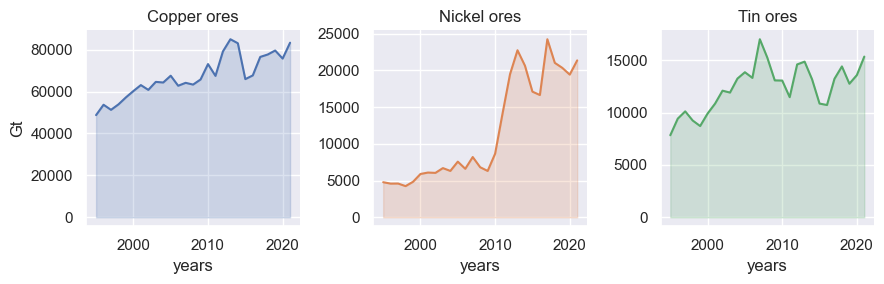

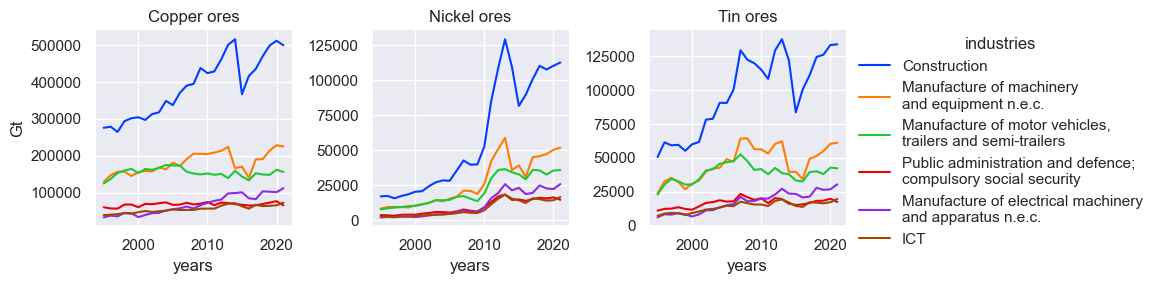

In [5]:
plot_minerals(dataframe=ict, agg_name="ICT", categories=mineral_categories, col_wrap=3)

plt.gcf().savefig("figures/ict_minerals.pdf", bbox_inches="tight")

plot_detailed_minerals(
    dataframe=ict_simp,
    industries_threshold=5,
    categories=mineral_categories,
    col_wrap=3,
    fill=False,
)

plt.gcf().savefig("figures/ict_minerals_detailed.pdf", bbox_inches="tight")

# Cumulated CBA footprint over the period


{'Construction', 'Manufacture of machinery and equipment n.e.c.', 'Manufacture of electrical machinery and apparatus n.e.c.', 'Manufacture of coke, refined petroleum products and nuclear fuel', 'Manufacture of other transport equipment', 'ICT', 'Research and development', 'Others', 'Manufacture of motor vehicles, trailers and semi-trailers', 'Manufacture of basic metals', 'Health and social work', 'Manufacture of food products and beverages', 'Manufacture of chemicals and chemical products', 'Manufacture of fabricated metal products, except machinery and equipment', 'Public administration and defence; compulsory social security'}


/var/folders/5_/wks2d2t50qb8f1pxwz7dctb80000gn/T/ipykernel_17849/1973607766.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(tick * 100)}%" for tick in ax.get_yticks()])


Index(['Manufacture of coke, refined petroleum products and nuclear fuel',
       'Manufacture of machinery and equipment n.e.c.', 'ICT',
       'Manufacture of food products and beverages',
       'Manufacture of motor vehicles, trailers and semi-trailers',
       'Research and development',
       'Public administration and defence; compulsory social security',
       'Health and social work', 'Construction',
       'Manufacture of chemicals and chemical products', 'Others'],
      dtype='object')

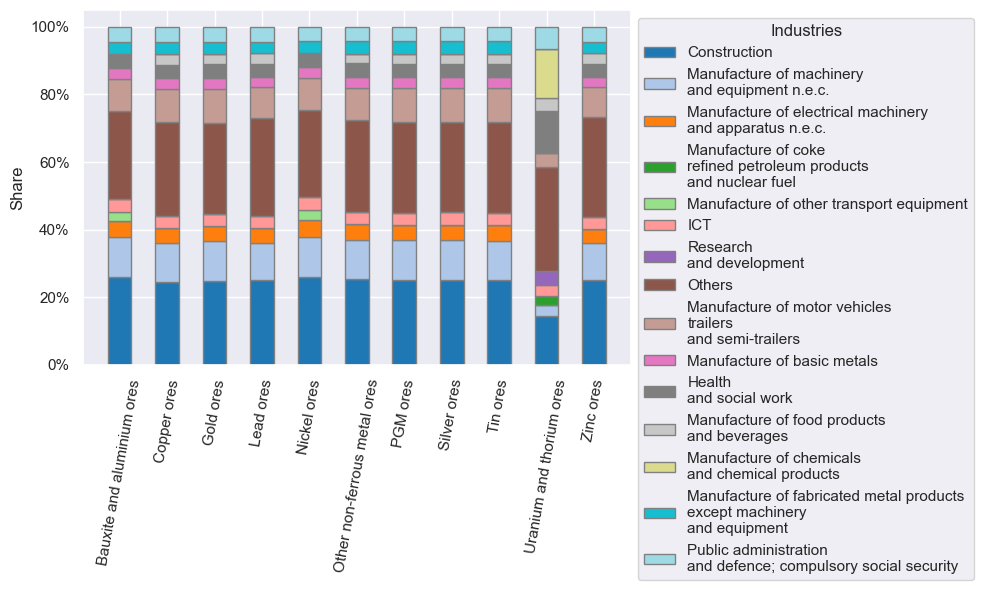

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Do not consider Mining industries
mask = ~ict_simp.index.get_level_values(1).str.contains("Mining")

# Apply the mask to the DataFrame to filter out the rows
df_filtered = ict_simp[mask]

# Assuming ict_simp and mineral_categories are defined and clear_mineral_stressors_name is a function defined elsewhere
# data = largest_industries
normalized_data = {}

for ore in mineral_stressors_used:
    # Retrieve largest industries
    a = df_filtered[ore].groupby(level=1).sum().nlargest(10)
    a["Others"] = df_filtered[ore].groupby(level=1).sum().drop(a.index).sum()

    # Normalize dataframe
    normalized_df = a.div(a.sum(axis=0), axis=0)

    # Get an easier to plot array
    normalized_data[clear_mineral_stressors_name(ore)] = normalized_df

# Get the complete list of industries across all ores
all_industries = set(
    industry for df in normalized_data.values() for industry in df.index
)

print(all_industries)

# Prepare data for plotting
ores = list(normalized_data.keys())

# Bar positions
bar_width = 0.5
r = np.arange(len(ores))

# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize bottom position for the stack bars
bottom = np.zeros(len(ores))

# Colors for the industries
colors = plt.cm.tab20(np.linspace(0, 1, len(all_industries)))

# Plotting each industry as a stack
for i, industry in enumerate(all_industries):
    values = []
    for ore in ores:
        if industry in normalized_data[ore].index:
            values.append(normalized_data[ore].loc[industry])
        else:
            values.append(0)
    ax.bar(
        r,
        values,
        bottom=bottom,
        color=colors[i],
        edgecolor="grey",
        width=bar_width,
        label=industry.replace(", ", "\n").replace(
            " and", "\nand"
        ),  # Use two lines for labels
    )
    bottom += values

# Adding Xticks
# ax.set_xlabel("Ores", fontweight="bold")
ax.set_ylabel("Share")
# ax.set_title(
#     "100% Stacked Bar Chart of Domestic Extraction Used - Metal Ores by Industry"
# )
ax.set_xticks(r)
ax.set_xticklabels(ores, rotation=80)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Industries")

# Change y-axis tick labels to percentage
ax.set_yticklabels([f"{int(tick * 100)}%" for tick in ax.get_yticks()])

# Show the plot
plt.tight_layout()
plt.gcf().savefig("figures/mineral_sum_share.pdf", bbox_inches="tight")

normalized_data["Uranium and thorium ores"].sort_values().index

In [7]:
normalized_data["Uranium and thorium ores"]

Manufacture of chemicals and chemical products                      0.144269
Construction                                                        0.143885
Health and social work                                              0.123211
Public administration and defence; compulsory social security       0.066530
Research and development                                            0.041459
Manufacture of motor vehicles, trailers and semi-trailers           0.040851
Manufacture of food products and beverages                          0.039540
ICT                                                                 0.033695
Manufacture of machinery and equipment n.e.c.                       0.033460
Manufacture of coke, refined petroleum products and nuclear fuel    0.026112
Others                                                              0.306988
Name: Domestic Extraction Used - Metal Ores - Uranium and thorium ores, dtype: float64

/var/folders/5_/wks2d2t50qb8f1pxwz7dctb80000gn/T/ipykernel_17849/974918955.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(tick * 100)}%" for tick in ax.get_yticks()])


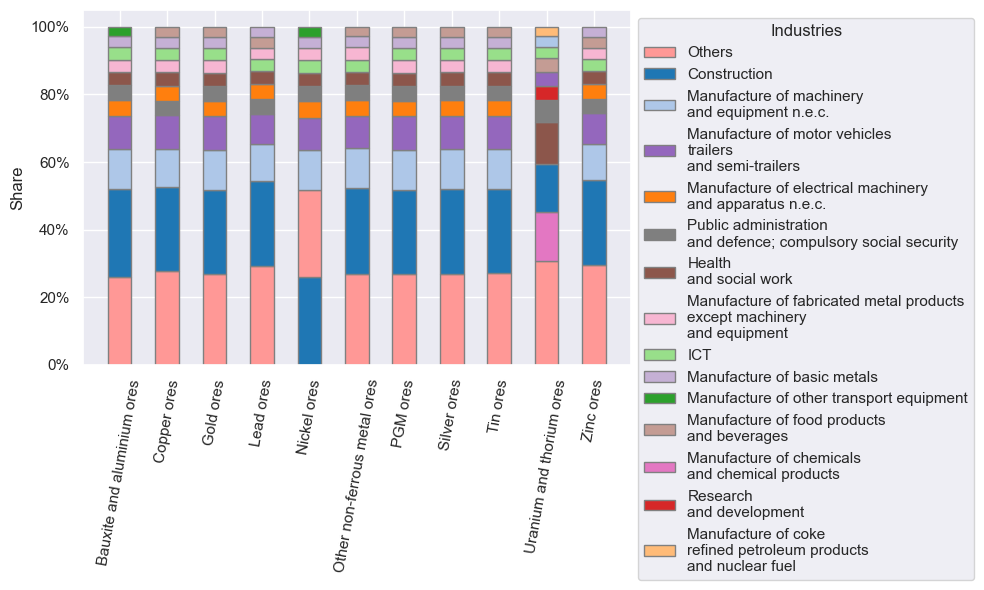

In [8]:
# Bar positions
bar_width = 0.5
r = np.arange(len(ores))

# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize bottom position for the stack bars
bottom = np.zeros(len(ores))

# Colors for the industries
colors_palette = sns.color_palette("tab20", len(all_industries) + 5)
# colors_palette= sns.color_palette("flare", as_cmap=True)

# Create a dictionary to map each label to a unique color
colors = {label: color for label, color in zip(all_industries, colors_palette)}

# Dictionary to track which industries have already been labeled
labeled_industries = set()

# Plot each ore separately, sorting industries for each ore by their contribution
for j, ore in enumerate(ores):
    # Sort industries by their contribution for this ore
    sorted_industries = normalized_data[ore].sort_values(ascending=False).index

    # Reset the bottom for each bar
    bottom[j] = 0

    # Plot each industry in sorted order
    for i, industry in enumerate(sorted_industries):
        value = normalized_data[ore][industry]

        # Plot only if the value is greater than 0
        if value > 0:
            # Label the industry only if it hasn't been labeled yet
            label = (
                industry.replace(", ", "\n").replace(" and", "\nand")
                if industry not in labeled_industries
                else ""
            )
            labeled_industries.add(industry)  # Mark the industry as labeled

            ax.bar(
                r[j],
                value,
                bottom=bottom[j],
                color=colors[industry],
                edgecolor="grey",
                width=bar_width,
                label=label,  # Use two lines for labels
            )
            bottom[j] += value

# Adding Xticks
# ax.set_xlabel("Ores", fontweight="bold")
ax.set_ylabel("Share")
# ax.set_title(
#     "100% Stacked Bar Chart of Domestic Extraction Used - Metal Ores by Industry"
# )
ax.set_xticks(r)
ax.set_xticklabels(ores, rotation=80)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Industries")

# Change y-axis tick labels to percentage
ax.set_yticklabels([f"{int(tick * 100)}%" for tick in ax.get_yticks()])

# Show the plot
plt.tight_layout()
plt.gcf().savefig("figures/mineral_sum_share.pdf", bbox_inches="tight")

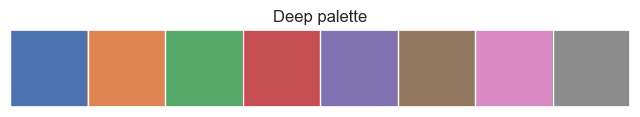

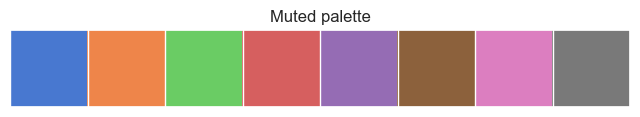

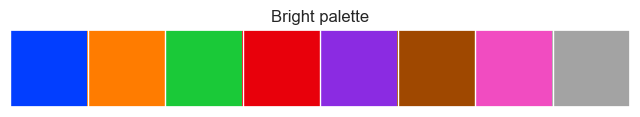

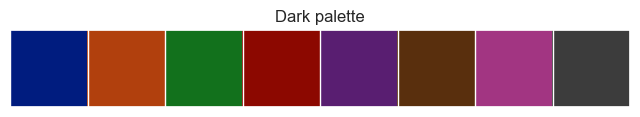

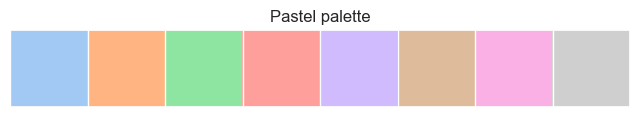

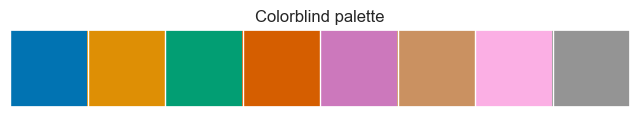

In [9]:
# Display a few built-in palettes with a varying number of colors
palettes = ["deep", "muted", "bright", "dark", "pastel", "colorblind"]

# Visualize the palettes
for palette in palettes:
    sns.palplot(sns.color_palette(palette, 8))
    plt.title(f"{palette.capitalize()} palette")
    plt.show()

# Try the evolution of this share for a single mineral


In [10]:
data = {}
category = "Domestic Extraction Used - Metal Ores - Bauxite and aluminium ores"

for year in ict_simp.index.get_level_values(0).unique():
    for industry in ict_simp.index.get_level_values(1).unique():
        data[(year, industry)] = ict_simp[category][(year, industry)]

# Create MultiIndex DataFrame
index = pd.MultiIndex.from_tuples(data.keys(), names=["year", "industry"])
df = pd.DataFrame(list(data.values()), index=index, columns=["value"])

# Normalize the data to sum to 100% for each year
df = df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

df

# Unstack the DataFrame to get years as columns and industries as rows
# df_unstacked = df.unstack(level=0).fillna(0)

# df_unstacked

/var/folders/5_/wks2d2t50qb8f1pxwz7dctb80000gn/T/ipykernel_17849/2813337416.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df = df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))


value
year year industry                                                    
1995 1995 Agriculture, hunting and related service activi...  1.224271
          Forestry, logging and related service activities    0.090248
          Fishing, operating of fish hatcheries and fish ...  0.119131
          Mining of coal and lignite; extraction of peat      0.048196
          Extraction of crude petroleum and natural gas; ...  0.219683
...                                                                ...
2021 2021 Activities of membership organizations n.e.c.       0.287062
          Recreational, cultural and sporting activities      0.606428
          Other service activities (93)                       0.613526
          Other service activities                            0.119368
          Extra-territorial organizations and bodies          0.000000

[1539 rows x 1 columns]

In [11]:
a = ict_simp[category].groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
a.index = a.index.droplevel(0)
test = a.unstack(level=0)
test.columns

Index([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021],
      dtype='int64')

/var/folders/5_/wks2d2t50qb8f1pxwz7dctb80000gn/T/ipykernel_17849/2512945038.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_normalized = df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))


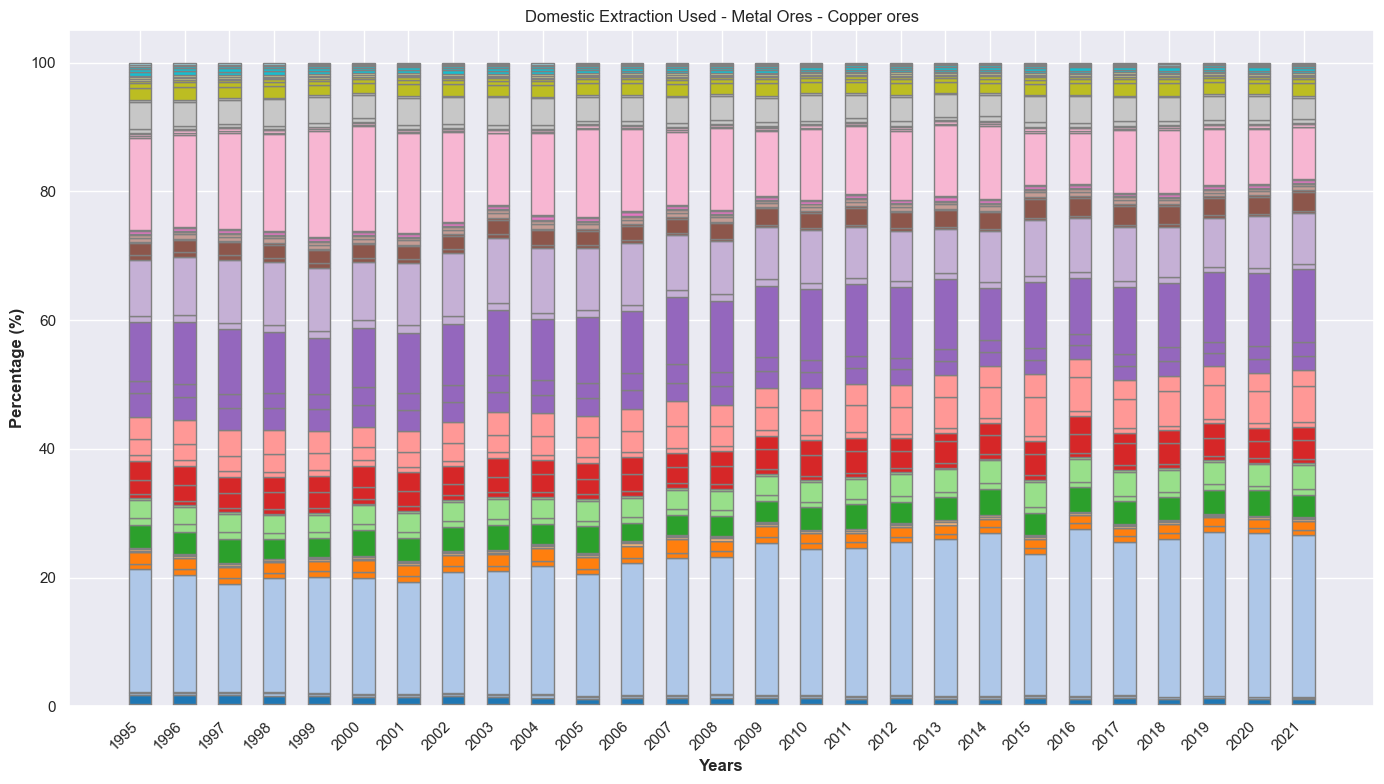

/var/folders/5_/wks2d2t50qb8f1pxwz7dctb80000gn/T/ipykernel_17849/2512945038.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_normalized = df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))


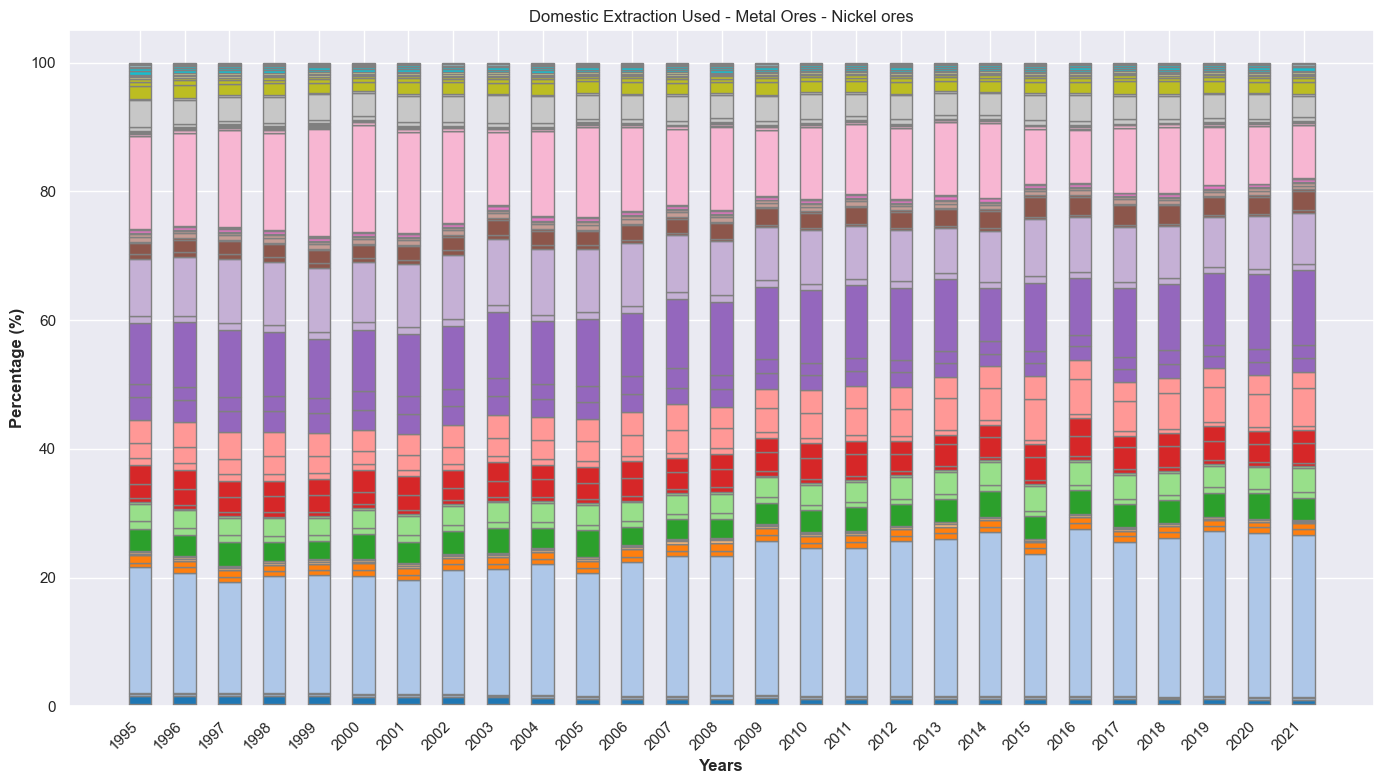

/var/folders/5_/wks2d2t50qb8f1pxwz7dctb80000gn/T/ipykernel_17849/2512945038.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_normalized = df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))


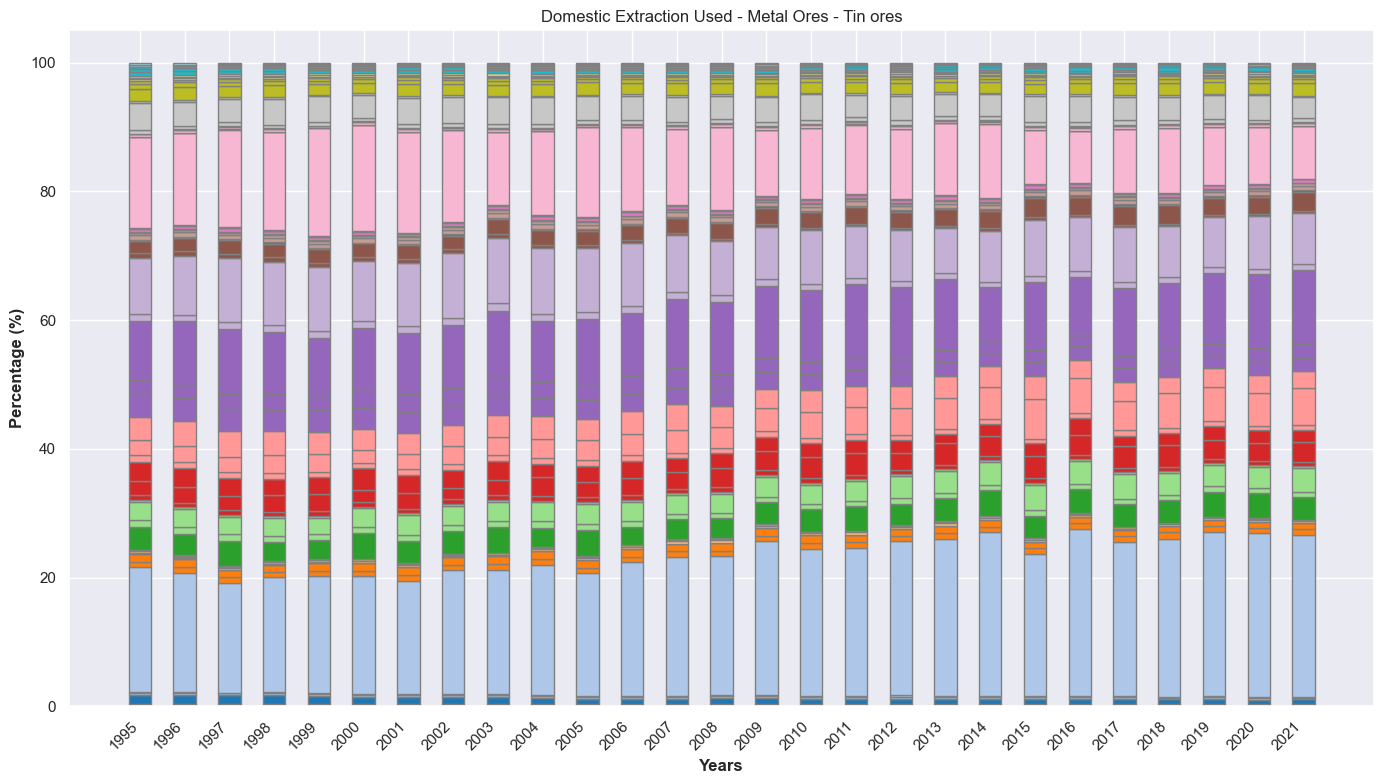

In [12]:
for category in mineral_categories:
    data = {}
    years = ict_simp.index.get_level_values(0).unique()
    industries = ict_simp.index.get_level_values(1).unique()

    for year in years:
        for industry in industries:
            data[(str(year), industry)] = ict_simp[category][(year, industry)]

    # data
    index = pd.MultiIndex.from_tuples(data.keys(), names=["year", "industry"])
    df = pd.DataFrame(list(data.values()), index=index, columns=["value"])
    # Normalize the data to sum to 100% for each year
    df_normalized = df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    # Remove the additional 'year' level introduced by groupby
    df_normalized.index = df_normalized.index.droplevel(0)
    # Unstack the DataFrame to get years as columns and industries as rows
    df_unstacked = df_normalized.unstack(level=0).fillna(0)

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 8))

    # Bar positions
    years = df_unstacked.columns.levels[1]
    industries = df_unstacked.index
    bar_width = 0.5
    r = np.arange(len(years))

    # Initialize bottom position for the stack bars
    bottom = np.zeros(len(years))

    # Colors for the industries
    colors = plt.cm.tab20(np.linspace(0, 1, len(industries)))

    # Plotting each industry as a stack
    for i, industry in enumerate(industries):
        values = df_unstacked.loc[industry].values
        ax.bar(
            r,
            values,
            bottom=bottom,
            color=colors[i],
            edgecolor="grey",
            width=bar_width,
            label=industry,
        )
        bottom += values

    # Adding Xticks
    ax.set_xlabel("Years", fontweight="bold")
    ax.set_ylabel("Percentage (%)", fontweight="bold")
    ax.set_title(category)
    ax.set_xticks(r)
    ax.set_xticklabels(years, rotation=45, ha="right")
    # ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Industries')

    # Show the plot
    plt.tight_layout()
    plt.show()